Introduction
--------------

**Ultrasound Signal Processing**

Ultrasound signals are also called ultrasound RF signals because of the frequencies that they carry. The main frequency is the one of the ultrasound transducer or resonator that is used to generate the acoustic wave and to receive the same wave that is reflected by tissues.

An ultrasound signal needs to be processed to obtain imaging information. The steps for forming an image in ultrasound are:

1. Generate an ultrasound mechanical/acoustical wave with the transducer which is usually done by exciting electrically this transducer using a pulser (square electrical pulse of about 900V peak and short duration)
2. Receive and digitize the ultrasound mechanical/acoustical wave by the transducer which is done by receiving the electrical signal from the transducer using a receiver (usually on the same like as the pulser, thus this device is commonly known as a pulser/receiver)
3. The recieved and later digitized signal will have a main frequency that is the central frequency of the transducer material used to generate the ultrasound wave, usually between 1 and 10 MHz
4. The signal is often digitized after limitation and then amplification:

   a. Limitation is performed to eliminate the large voltage pulse sent to the transducer (the received signal is in the order of 2mV while the pulse is 900V)
   
   b. Amplification is performed after limitation and it requires usually about 40dB in gain to boost the signal to values required by most acquisition cards (around 2V)

5. After acquisition we need to compensate for attenuation

6. We finally require to obtain the intensity of each pixel by the envelope of the signal

7. We repeat for all lines

We will open and analyse the signal acquired from a pulser/receiver which was digitized by a 12-bit acquisition card sampling at $125 MHz$ with a $2 Vpp$ maximum voltage. The file provided has one single line coming from this pulser/receiver and it is stored in the file $SingleUSSignalI.dat$. The data in this file was stored by the acquisition card as unsigned integers of 16 bits.

We will first plot the signal with the time scale:

Depth Imaged: 0.291588325653
Sampling frequency: 20832000.0


<IPython.core.display.Javascript object>


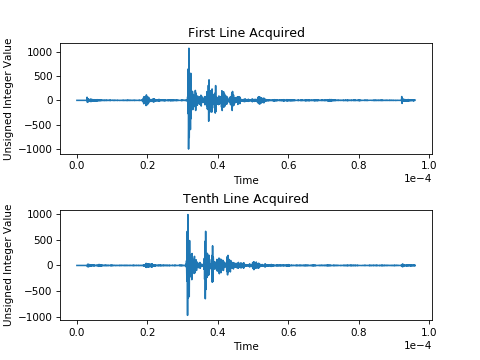

In [2]:
#we have first this command that initialize and matplotlib (library) for plotting and we specify that we want those plots inline in this notebook
%matplotlib nbagg

#now we import different packages that will allow to do math, lineal algebra, numerical operations, array operations and plotting
import scipy as Sci
import scipy.linalg
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from scipy.signal import hilbert

#we use a simple open command for the file (basic Python)
#Attention, the file has ALL the lines, so to show just one in this example we need to know that there is only 4096 points to graph
f = open('LabRFdata.bin','rb')   # Windows
#we read it using a numpy (therefore the np.) command that allows direct reading from file into an array
RFLines = np.fromfile(f,count=-1,dtype=np.int16)
L=4096
fc=5.208e6
c=1483
vlambda=c/fc
TotalDistance=4096/4*vlambda
Time=TotalDistance/c
print('Depth Imaged: ' + str(TotalDistance))
LineF = RFLines[:L]*1.
f.close() #close the file
#we will now populate an array for the time which we now is 1/125MHz step for a total of 15000
x=np.arange(0,Time,Time/L)  #start,stop,step
fs=1/(Time/L)
print('Sampling frequency: '+ str(fs))
#now we plot only the first line acquired (4096 samples)
plt.plot(x,LineF[:L])
plt.show
plt.title('Singe Line Acquired')
plt.xlabel('Time')
plt.ylabel('Integer Value')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))



We will analyze this signal visually (zoom) to estimate the frequency of the transducer used.

We will then perform a Fourier transform to obtain the central frequency of the transducer.

In [3]:
inx1=np.where(x>7.844e-5)
inx1=inx1[0]
inx2=np.where(x>7.867e-5)
inx2=inx2[0]
plt.plot(x[inx1[0]:inx2[0]],LineF[inx1[0]:inx2[0]])
plt.title('Zoom of Singe Line Acquired')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

Since 1 cycle of the signal are between $7.84\times 10^{-5}$ and $7.867\times ^{-5}$ we then have a frequency of $\frac{1}{(7.867\times 10^{-5}-7.84\times 10^{-5})}=4.35MHz$

We will now obtain this using DFT. Note: just as we did before, we will take away the dc component!

In [4]:
#Eliminating dc
LineF-=np.mean(LineF)
#Now let's obtain the spectrum
#the frequencies after fft will be between 0 and 1/2 of the sampling frequency
f=np.arange(0,fs/2,fs/L)
Y=np.fft.fft(LineF)
Pyy=abs(Y)/L
#note: we are showing just L/2 elements which are the positive frequencies and we are normalizing

#preparing the plotting
plt.subplots_adjust( wspace = 1.5 )
plt.subplot(121)
L2=len(Pyy)/2

plt.plot(f[:L2], Pyy[:L2])
plt.title('DFT')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#Zooming into just less than 8MHz
inx=np.where(f>8e6)
inx=inx[0]
plt.subplot(122)
plt.plot(f[:inx[0]], Pyy[:inx[0]])
plt.title('DFT')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#Let's obtain the frequency at which the maximum is observed
#Remember we have a DFT which is mirrored, so we only work with half
PyyM=Pyy[:L2]
mm=np.argmax(PyyM) #this gives the index where the max is found
print("The maximum is %f and it is found at index %d which is the frequency %e" % (max(PyyM),mm,f[mm]))

The maximum is 4.576372 and it is found at index 1175 which is the frequency 5.975977e+06


We can see that the frequency of that transducer is $4.46MHz$ and as you can see, using the DFT gave us more precision than estimation.
The center of the bandwidth of this transducer is clearly seen (use zoom) at the $5MHz$ that the transducer works at

Assuming that the tissues have attenuated this signal $4Np/m/MHz$ we will compensate for this attenuation and plot the real time-gain-compensated signal. The attenuation is exponential so we can compensate using:

$$ RF_{com}=RF e^{\mu d}\;\;\mu=\alpha f\;\;\;\;\;d=ct\;\;\;c\approx 1450m/s$$

We should also limit the signal since it has the large excitation pulse 


In [5]:
#Compensating (water only)
Att=0.0022
h=x*1450
ffatt=np.exp(Att*fc/1e6*h)
LineF[0:30]=0
LineC=LineF*ffatt
#Plotting
plt.subplot(121)
plt.plot(x,LineF[:L])
plt.title('Before compensation')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(122)
plt.plot(x,LineC[:L])
plt.title('After compensation')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

C:\Users\kaurs\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


To prepare for forming an image, we will now obtain the envelope of the signal and plot. This is done using a Hilbert transform.

In [6]:
#Hilbert Transform
LineE=hilbert(LineC)
LineE=abs(LineE)
#Plotting
plt.subplot(121)
plt.plot(x,LineC[:L])
plt.title('RF signal compensated')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(122)
plt.plot(x,LineE[:L])
plt.title('Envelope of the RF')
plt.xlabel('Time')
plt.ylabel('V')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

**Ultrasound Imaging Processing**

We can obtain an image by repeating all those operations this time on multiple lines RF. Using the file $MultipleUSSignalsI.dat$ with the same format as before we will obtain the image.


In [7]:
#we have the lines in RFLines
#we will now populate a 2D matrix for the lines
TL=len(RFLines)/L
print('The total lines are:'+str(TL))
RFLinesF=RFLines*1.-np.mean(RFLines*1.)
LinesRF=RFLinesF.reshape(TL,L).copy()  #columns,rows
#limiting all the lines
LinesRF[:,0:60]=0
LinesRFLim=LinesRF[:,0:2000]
xLim=x[0:2000]
hLim=h[0:2000]
#now we plot two lines acquired to double check 
print(np.shape(LinesRFLim))
plt.subplots_adjust( hspace = .5 )
plt.subplot(211)
plt.plot(xLim,LinesRFLim[0,:]) #first line
plt.title('First Line Acquired')
plt.xlabel('Time')
plt.ylabel('Unsigned Integer Value')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.subplot(212)
plt.plot(xLim,LinesRFLim[10,:]) #10th line
plt.title('Tenth Line Acquired')
plt.xlabel('Time')
plt.ylabel('Unsigned Integer Value')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

The total lines are:128
(128L, 2000L)


We will now compensate attenuation and apply the Hilbert transform to all the 2D array.

And we can then create the image (it should be logarithmic).


<IPython.core.display.Javascript object>


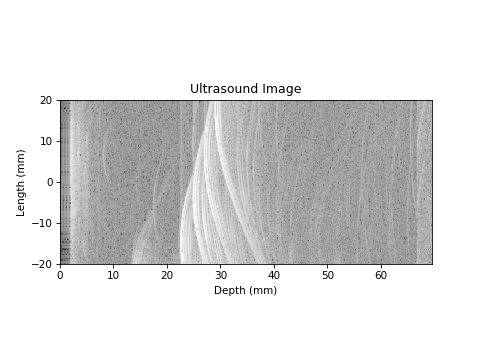

<IPython.core.display.Javascript object>


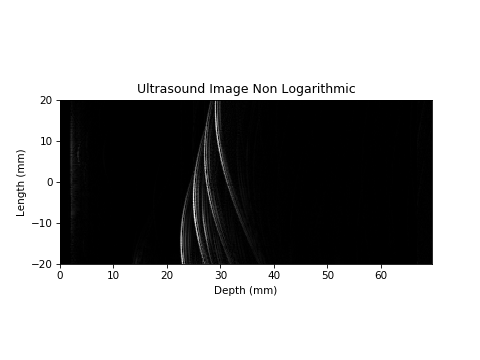

Text(0,0.5,u'Length (mm)')

In [8]:
#Compensating
ffatt=np.exp(Att*fc/1e6*hLim)
LinesRFC=LinesRFLim*ffatt
LinesRFE=hilbert(LinesRFC)
LinesRFE=abs(LinesRFE)

#images need to be logarithmic so we can see all the contrast
Mx=LinesRFE.max()
Image=20*np.log10(LinesRFE/Mx)
ImageBW=LinesRFE

#the line axis
s=np.linspace(-20,20,TL)
#Plotting
d=hLim/2*1000  #answer: why are we doing this here?
plt.figure()
plt.set_cmap(plt.gray()) #grayscale
plt.pcolormesh(d, s, Image[:, :])
plt.axis([d.min(),d.max(),s.min(),s.max()])
plt.axes().set_aspect(10./13)  #this is because I know the image was 20mm in lenght so 26 lines=20mm or a ratio 10/13
plt.title('Ultrasound Image')
plt.xlabel('Depth (mm)')
plt.ylabel('Length (mm)')

plt.figure()
plt.set_cmap(plt.gray()) #grayscale
plt.pcolormesh(d, s, ImageBW[:, :])
plt.axis([d.min(),d.max(),s.min(),s.max()])
plt.axes().set_aspect(10./13)
plt.title('Ultrasound Image Non Logarithmic')
plt.xlabel('Depth (mm)')
plt.ylabel('Length (mm)')

We will finally apply one of the most common filters that are used in ultrasound imaging: the median filter. This will make the image less "grainy" to the user.
We will also implement a usual "cutoff" in the displayed image, anything less than -60dB will be eliminated.

<IPython.core.display.Javascript object>


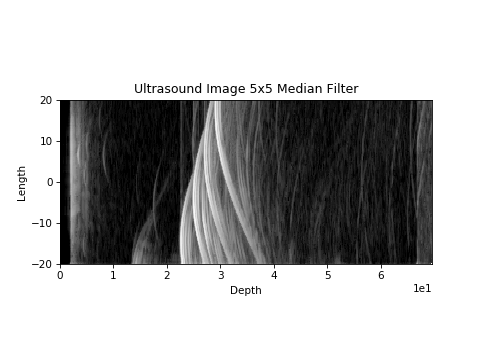

In [9]:
from scipy.signal import medfilt

#we cut anything below -60dB
cutdb=-60
inx=np.where(Image<cutdb)
Image[inx]=cutdb

#and we filter using a 5x5 median filter
ImageF=medfilt(Image,5)

#Plotting
d=hLim/2*1000
plt.figure()
plt.set_cmap(plt.gray()) #grayscale
plt.pcolormesh(d, s, ImageF[:, :])
plt.axis([d.min(),d.max(),s.min(),s.max()])
plt.axes().set_aspect(10./13)
plt.title('Ultrasound Image 5x5 Median Filter')
plt.xlabel('Depth')
plt.ylabel('Length')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


## Summary

In this example, we rendered an ultrasound image from RF signals acquired with a pulser/receiver.

Test your knowledge:

* Find out and discuss the effect of modifying the filter and explain briefly how a median filter works
* Do you expect that if we process the image using the converted signal into voltage this will change the aspect in your image? why or why not?
* What is the meaning of dB or logarithmic imaging?
* What is the effect of changing the attenuation coefficient? Would it affect the image much if different tissues have different attenuations?
* Why do we use a Hilbert transform to obtain the envelope?\\

Comments and corrections welcome!

References
---------------

* Oppenheim, A. V., and A. S. Willsky. "Signals and Systems." Prentice-Hall, (1997).